# H12 signal detection

## Notebook parameters

In [1]:
cohort_id = 'BF-09_Houet_colu_2012_Q3'
sample_sets = "AG1000G-BF-A"
cohorts_analysis = "20230223"
max_cohort_size = 50

## Setup

In [2]:
import yaml
import pandas as pd
import malariagen_data
from pyprojroot import here
import numpy as np
import os
import matplotlib.pyplot as plt
from bisect import bisect_left, bisect_right
import lmfit
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
%run {here()}/workflow/notebooks/peak-utils.ipynb

In [4]:
sample_sets

['AG1000G-BF-A']

In [5]:
ag3 = malariagen_data.Ag3(
    # TODO in production build, remove use of simplecache if running inside google cloud
    # url = "gs://vo_agam_release",
    url="simplecache::gs://vo_agam_release",
    # pin the version of the cohorts analysis for reproducibility
    cohorts_analysis=cohorts_analysis,
    # TODO remove simplecache config in production
    simplecache=dict(cache_storage=(here() / "gcs_cache").as_posix()),
    results_cache=(here() / "malariagen_data_cache").as_posix(),
)
ag3

<MalariaGEN Ag3 API client>
Storage URL             : simplecache::gs://vo_agam_release
Data releases available : 3.0
Results cache           : /home/aliman/github/anopheles-genomics-surveillance/selection-atlas/malariagen_data_cache
Cohorts analysis        : 20230223
Species analysis        : aim_20220528
Site filters analysis   : dt_20200416
Software version        : malariagen_data 7.3.0
Client location         : England, GB
---
Please note that data are subject to terms of use,
for more information see https://www.malariagen.net/data
or contact data@malariagen.net. For API documentation see 
https://malariagen.github.io/vector-data/ag3/api.html

In [6]:
# load window sizes from output of h12-calibration
calibration_dir = "build/h12-calibration"
with open(here() / calibration_dir/ f"{cohort_id}.yaml") as calibration_file:
    calibration_params = yaml.safe_load(calibration_file)
window_size = calibration_params["h12_window_size"]
window_size

1000

In [7]:
# load cohorts to find sample query 
df_cohorts = pd.read_csv(here() / "build" / "cohorts.csv").set_index("cohort_id")
cohort = df_cohorts.loc[cohort_id]
cohort

cohort_size                                                    78
country                                              Burkina Faso
admin1_iso                                                  BF-09
admin1_name                                         Hauts-Bassins
admin2_name                                                 Houet
taxon                                                    coluzzii
year                                                         2012
quarter                                                         3
cohort_label          Burkina Faso / Houet / coluzzii / 2012 / Q3
sample_query    cohort_admin2_quarter == 'BF-09_Houet_colu_201...
Name: BF-09_Houet_colu_2012_Q3, dtype: object

In [8]:
sample_query = cohort.sample_query
sample_query

"cohort_admin2_quarter == 'BF-09_Houet_colu_2012_Q3' and sex_call == 'F'"

In [9]:
if cohort.taxon == 'arabiensis':
    phasing_analysis = 'arab'
else:
    phasing_analysis = 'gamb_colu'
phasing_analysis

'gamb_colu'

In [10]:
if cohort.cohort_size > max_cohort_size:
    # downsampling for computational efficiency
    cohort_size = max_cohort_size
else:
    # no downsampling
    cohort_size = None 
cohort_size

50

In [11]:
# plot the H12 results here as well for convenience
ag3.plot_h12_gwss(
    contig=contig, 
    window_size=window_size, 
    analysis=phasing_analysis, 
    sample_sets=sample_sets,
    sample_query=sample_query, 
    cohort_size=cohort_size
)

## Run signal detection

In [12]:
# set parameters for signal detection
filter_size = 20  # hampel filter parameter
filter_t = 2  # hampel filter parameter
gflanks = (4, 8)  # sizes of flanks in cM
scan_interval = 1  # step in cM
min_delta_aic = 500  # minimum evidence to emit a signal
min_baseline = 0
max_baseline_percentile = 95
min_amplitude = 0.03
init_amplitude = 0.5
max_amplitude = 1.5
min_decay = 0.1
init_decay = 0.5 
max_abs_skew = 0.5
scan_start = None
scan_stop = None
# TODO maybe set false in production to avoid too many plots?
debug = True

In [13]:
# load gwss data
ppos, h12 = ag3.h12_gwss(
    contig=contig, 
    window_size=window_size, 
    analysis=phasing_analysis, 
    sample_sets=sample_sets,
    sample_query=sample_query, 
    cohort_size=cohort_size
)

In [14]:
# convert to int
ppos = ppos.astype(int)

In [15]:
# map physical to genetic position
gpos = ag_p2g(contig=contig, ppos=ppos)

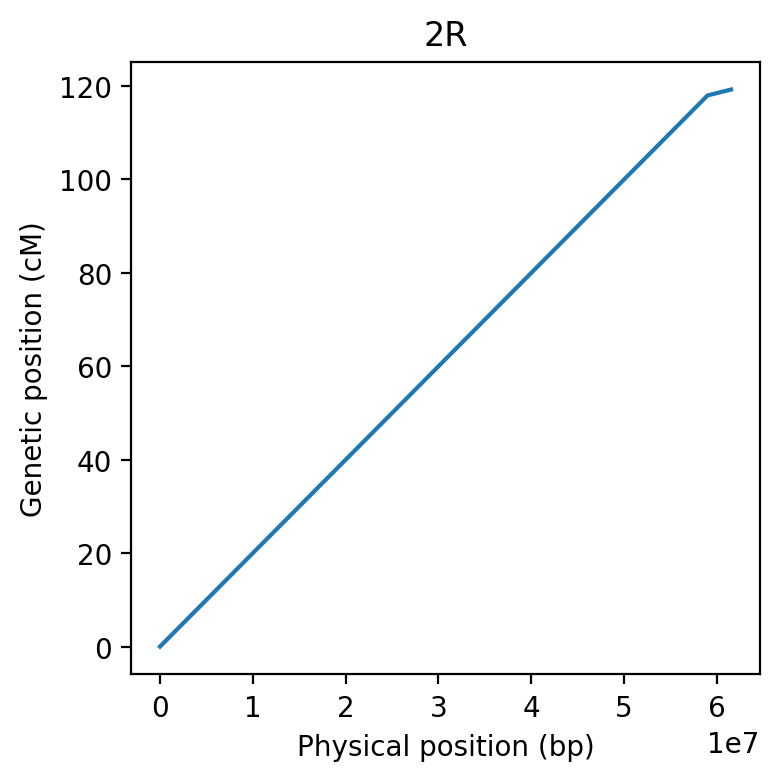

In [16]:
if debug:
    # quick check of genetic map
    fig, ax = plt.subplots(figsize=(4, 4))
    ax.plot(ppos, gpos)
    ax.set_xlabel('Physical position (bp)')
    ax.set_ylabel('Genetic position (cM)')
    ax.set_title(contig)
    fig.tight_layout()


In [17]:
# filter outliers
h12_filtered = hampel_filter(h12, size=filter_size, t=filter_t)

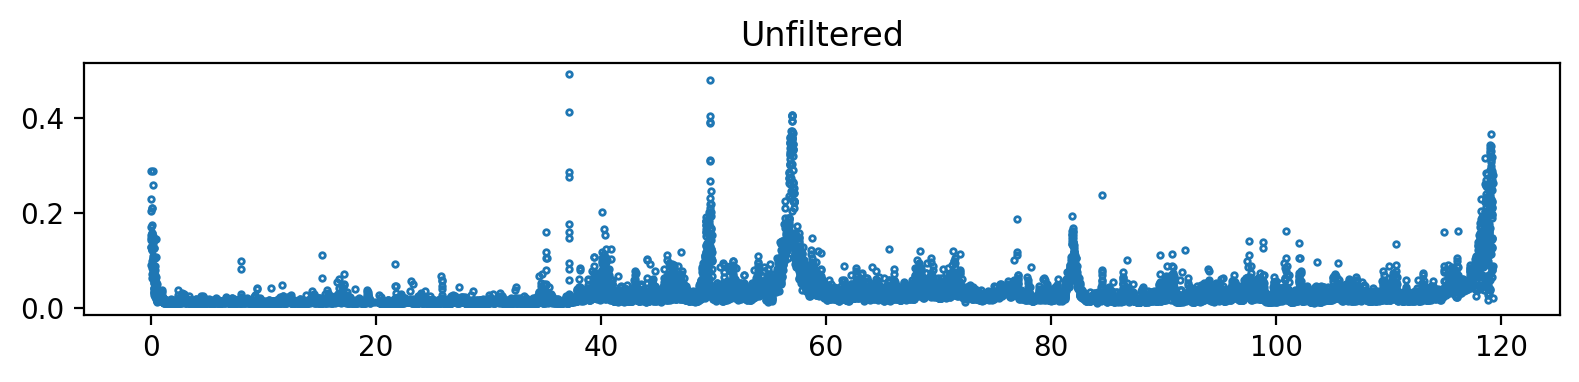

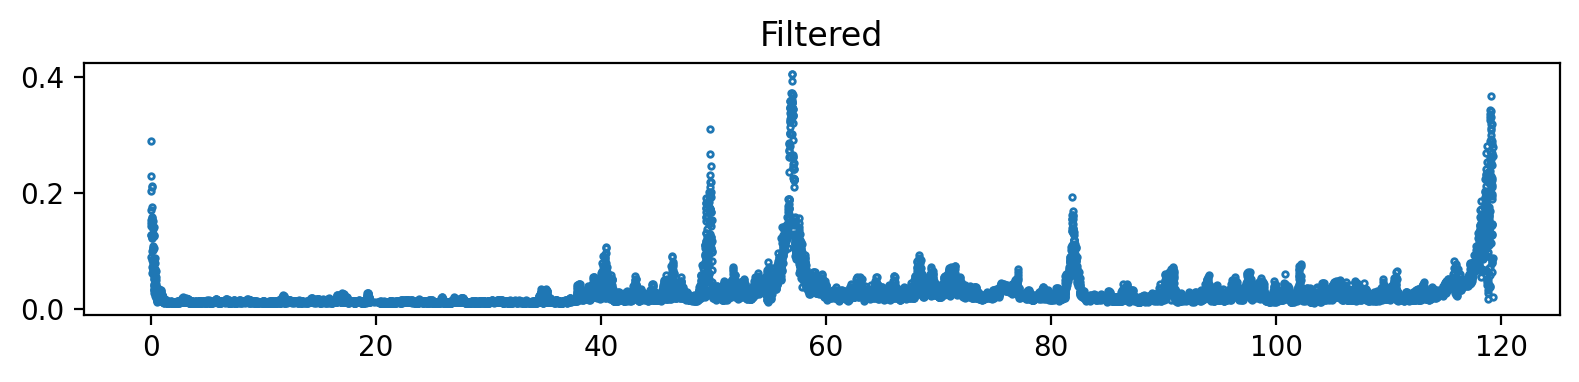

In [18]:
if debug:

    # before filtering
    fig, ax = plt.subplots(figsize=(8, 2))
    ax.plot(gpos, h12, marker='o', linestyle=' ', mfc='none', markersize=2)
    ax.set_title('Unfiltered')
    fig.tight_layout()

    # after filtering
    fig, ax = plt.subplots(figsize=(8, 2))
    ax.plot(gpos, h12_filtered, marker='o', linestyle=' ', mfc='none', markersize=2)
    ax.set_title('Filtered')
    fig.tight_layout()


In [19]:
# set parameters
init_baseline = np.median(h12_filtered)
max_baseline = np.percentile(h12_filtered, max_baseline_percentile)
min_skew, init_skew, max_skew = -max_abs_skew, 0, max_abs_skew
if not scan_start:
    scan_start = 2
if not scan_stop:
    scan_stop = gpos[-1] - 2

center 2.0 flank size 4
center 2.0 flank size 8
center 3.0 flank size 4
center 3.0 flank size 8
center 4.0 flank size 4
center 4.0 flank size 8
center 5.0 flank size 4
center 5.0 flank size 8
center 6.0 flank size 4
center 6.0 flank size 8
center 7.0 flank size 4
center 7.0 flank size 8
center 8.0 flank size 4
center 8.0 flank size 8
center 9.0 flank size 4
center 9.0 flank size 8
center 10.0 flank size 4
center 10.0 flank size 8
center 11.0 flank size 4
center 11.0 flank size 8
center 12.0 flank size 4
center 12.0 flank size 8
center 13.0 flank size 4
center 13.0 flank size 8
center 14.0 flank size 4
center 14.0 flank size 8
center 15.0 flank size 4
center 15.0 flank size 8
center 16.0 flank size 4
center 16.0 flank size 8
center 17.0 flank size 4
center 17.0 flank size 8
center 18.0 flank size 4
center 18.0 flank size 8
center 19.0 flank size 4
center 19.0 flank size 8
center 20.0 flank size 4
center 20.0 flank size 8
center 21.0 flank size 4
center 21.0 flank size 8
center 22.0 flan

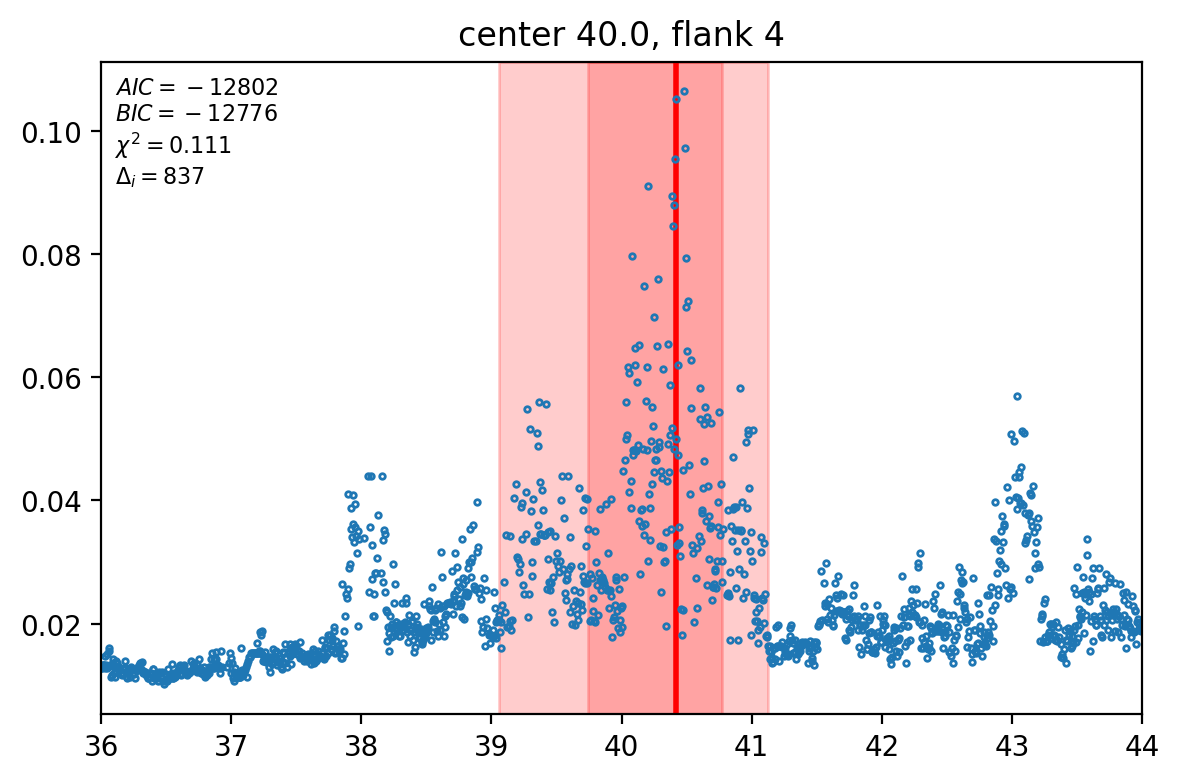

[[Model]]
    Model(skewed_exponential_peak)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 134
    # data points      = 1361
    # variables        = 5
    chi-square         = 0.11106119
    reduced chi-square = 8.1904e-05
    Akaike info crit   = -12801.9763
    Bayesian info crit = -12775.8964
    R-squared          = 0.46252720
[[Variables]]
    center:     40.4195239 +/- 0.01735926 (0.04%) (init = 40)
    amplitude:  0.03753418 +/- 0.00132466 (3.53%) (init = 0.5)
    decay:      0.48930672 +/- 0.03193379 (6.53%) (init = 0.5)
    skew:       0.47379638 +/- 0.07807089 (16.48%) (init = 0)
    baseline:   0.01895585 +/- 3.4639e-04 (1.83%) (init = 0.0202)
    ceiling:    1 (fixed)
    floor:      0 (fixed)
[[Correlations]] (unreported correlations are < 0.100)
    C(center, skew)     = 0.693
    C(decay, baseline)  = -0.559
    C(amplitude, decay) = -0.539
    C(decay, skew)      = -0.246
    C(center, decay)    = -0.180
center 40.0 flank size 8


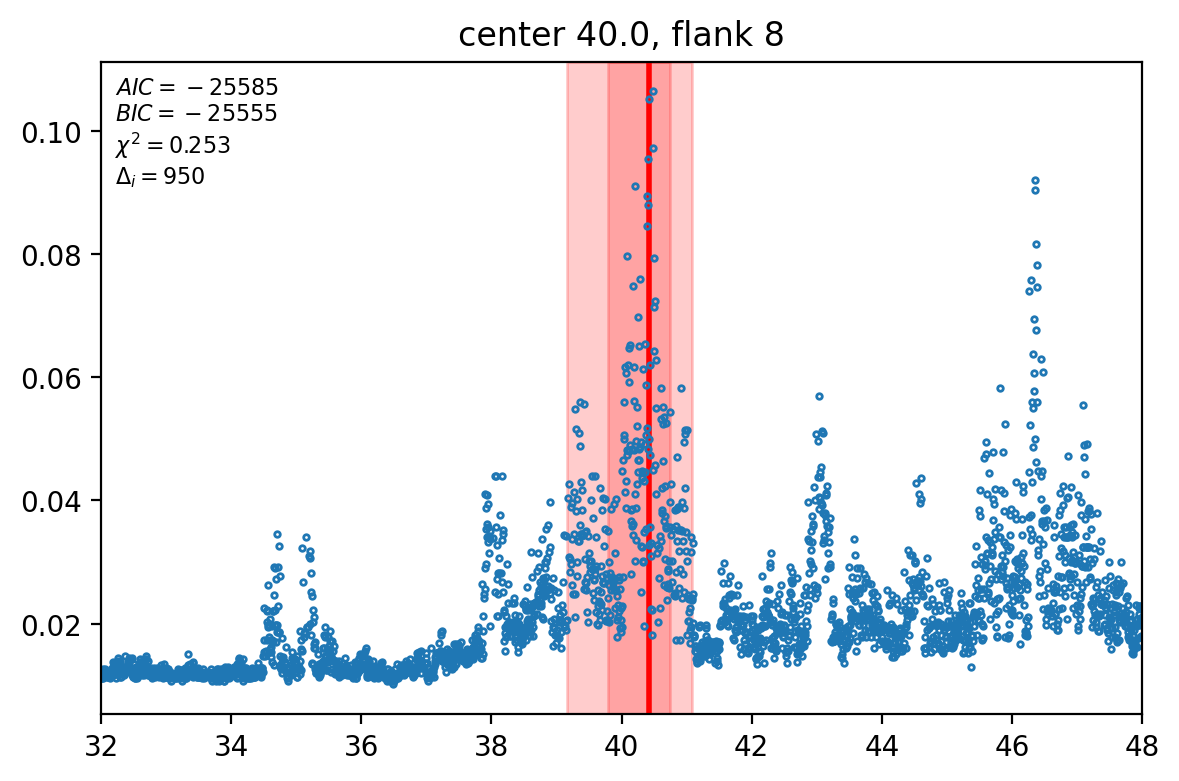

[[Model]]
    Model(skewed_exponential_peak)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 122
    # data points      = 2754
    # variables        = 5
    chi-square         = 0.25337662
    reduced chi-square = 9.2170e-05
    Akaike info crit   = -25584.8166
    Bayesian info crit = -25555.2125
    R-squared          = 0.29377192
[[Variables]]
    center:     40.4195228 +/- 0.01782264 (0.04%) (init = 40)
    amplitude:  0.03749154 +/- 0.00145220 (3.87%) (init = 0.5)
    decay:      0.45803034 +/- 0.02902802 (6.34%) (init = 0.5)
    skew:       0.46482333 +/- 0.08561904 (18.42%) (init = 0)
    baseline:   0.01959664 +/- 2.0893e-04 (1.07%) (init = 0.0202)
    ceiling:    1 (fixed)
    floor:      0 (fixed)
[[Correlations]] (unreported correlations are < 0.100)
    C(center, skew)     = 0.693
    C(amplitude, decay) = -0.619
    C(decay, baseline)  = -0.351
    C(decay, skew)      = -0.268
    C(center, decay)    = -0.194
center 41.0 flank size 4


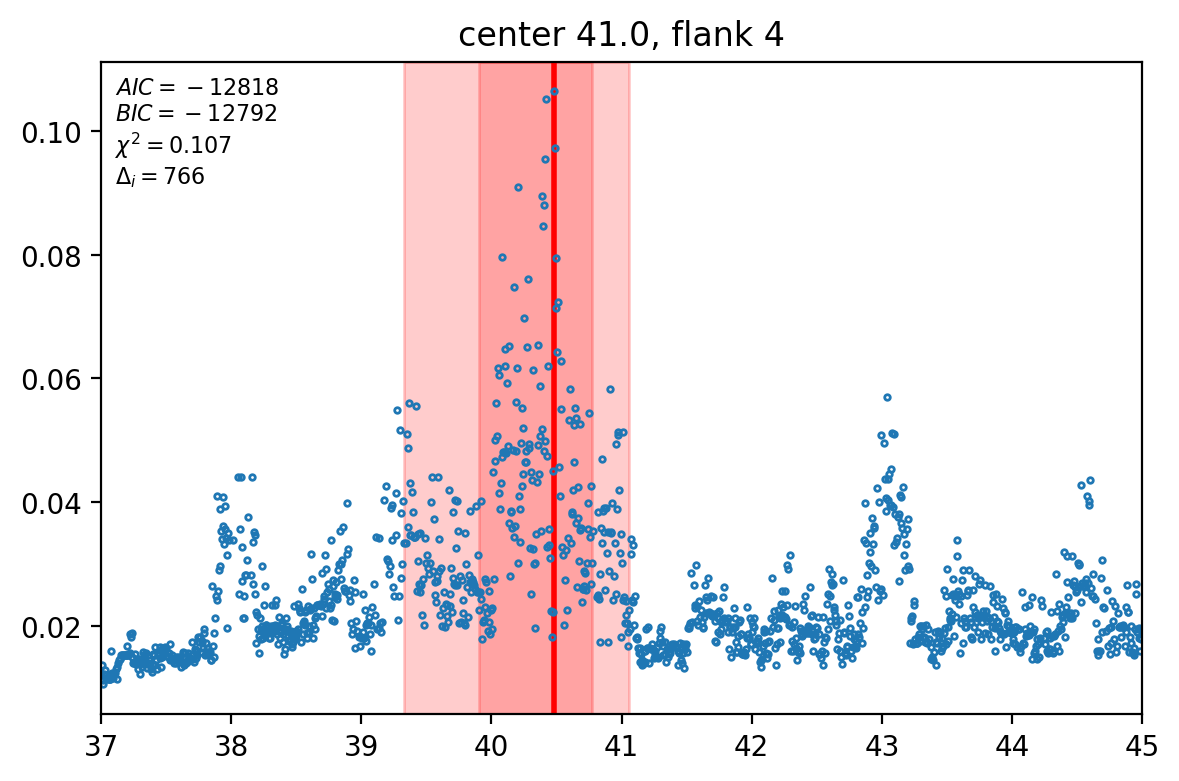

[[Model]]
    Model(skewed_exponential_peak)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 123
    # data points      = 1358
    # variables        = 5
    chi-square         = 0.10724066
    reduced chi-square = 7.9261e-05
    Akaike info crit   = -12818.2765
    Bayesian info crit = -12792.2077
    R-squared          = 0.43437994
[[Variables]]
    center:     40.4806980 +/- 0.01611131 (0.04%) (init = 41)
    amplitude:  0.03721649 +/- 0.00145003 (3.90%) (init = 0.5)
    decay:      0.40823719 +/- 0.02795060 (6.85%) (init = 0.5)
    skew:       0.49998624 +/- 0.08609828 (17.22%) (init = 0)
    baseline:   0.02084132 +/- 3.1598e-04 (1.52%) (init = 0.0202)
    ceiling:    1 (fixed)
    floor:      0 (fixed)
[[Correlations]] (unreported correlations are < 0.100)
    C(center, skew)     = 0.704
    C(amplitude, decay) = -0.580
    C(decay, baseline)  = -0.490
    C(decay, skew)      = -0.281
    C(center, decay)    = -0.211
center 41.0 flank size 8


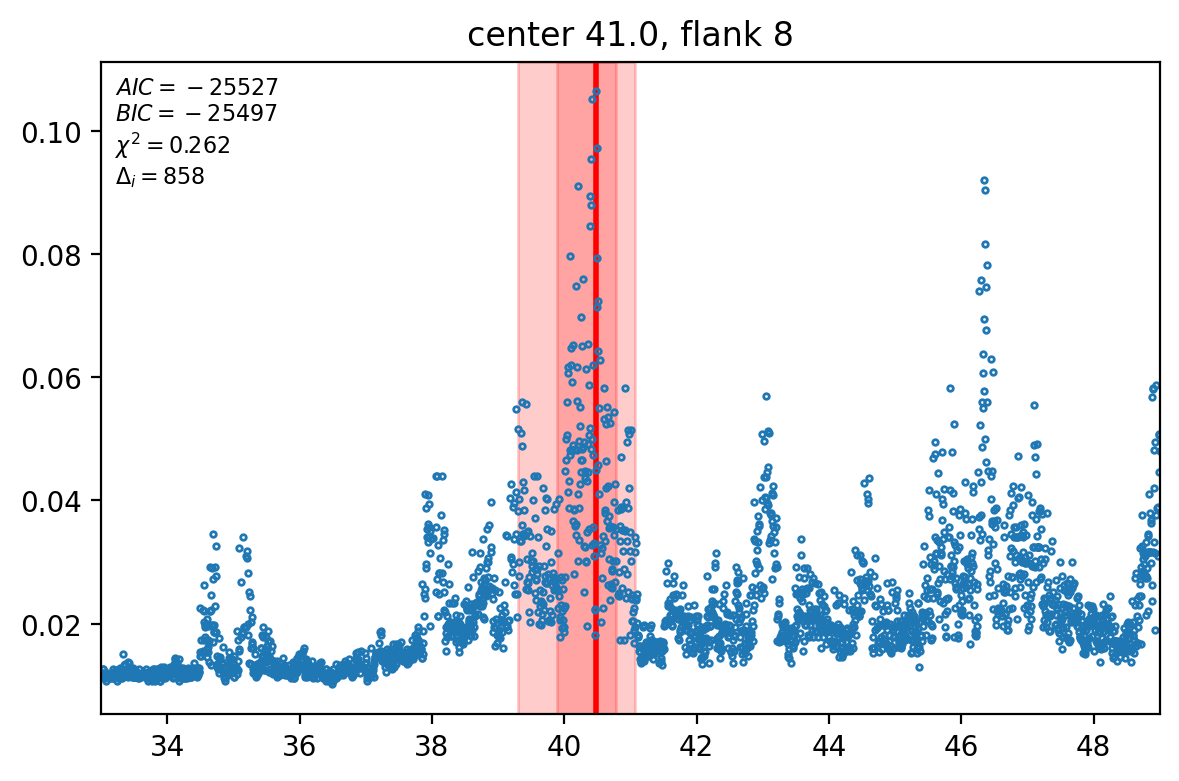

[[Model]]
    Model(skewed_exponential_peak)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 83
    # data points      = 2757
    # variables        = 5
    chi-square         = 0.26170218
    reduced chi-square = 9.5095e-05
    Akaike info crit   = -25526.5651
    Bayesian info crit = -25496.9556
    R-squared          = 0.26943752
[[Variables]]
    center:     40.4806980 +/- 0.01765038 (0.04%) (init = 41)
    amplitude:  0.03753011 +/- 0.00157442 (4.20%) (init = 0.5)
    decay:      0.41525791 +/- 0.02825981 (6.81%) (init = 0.5)
    skew:       0.49995025 +/- 0.09270783 (18.54%) (init = 0)
    baseline:   0.02051158 +/- 2.0932e-04 (1.02%) (init = 0.0202)
    ceiling:    1 (fixed)
    floor:      0 (fixed)
[[Correlations]] (unreported correlations are < 0.100)
    C(center, skew)     = 0.704
    C(amplitude, decay) = -0.633
    C(decay, baseline)  = -0.329
    C(decay, skew)      = -0.300
    C(center, decay)    = -0.226
center 42.0 flank size 4
center 42.

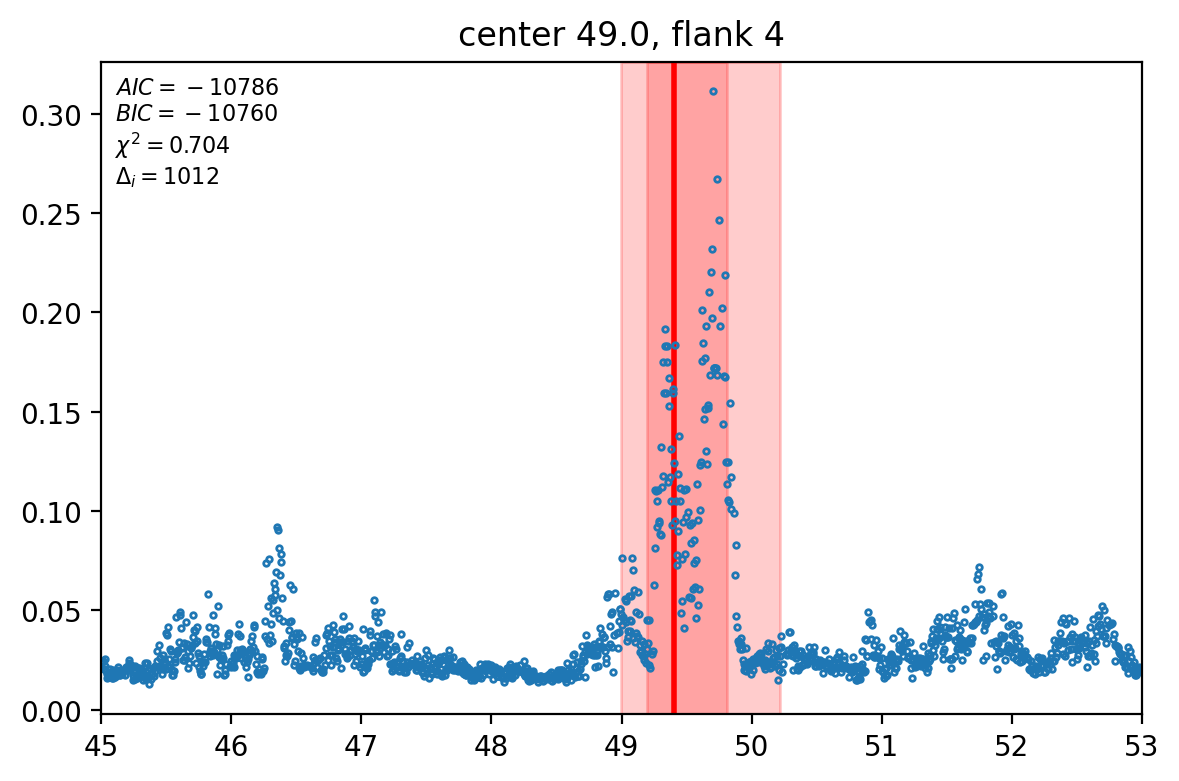

[[Model]]
    Model(skewed_exponential_peak)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 92
    # data points      = 1419
    # variables        = 5
    chi-square         = 0.70417196
    reduced chi-square = 4.9800e-04
    Akaike info crit   = -10786.3769
    Bayesian info crit = -10760.0883
    R-squared          = 0.51264992
[[Variables]]
    center:     49.4017722 +/- 0.00964552 (0.02%) (init = 49)
    amplitude:  0.12504922 +/- 0.00415271 (3.32%) (init = 0.5)
    decay:      0.28914498 +/- 0.01611765 (5.57%) (init = 0.5)
    skew:      -0.50000000 +/- 3.0897e-05 (0.01%) (init = 0)
    baseline:   0.02650724 +/- 7.1026e-04 (2.68%) (init = 0.0202)
    ceiling:    1 (fixed)
    floor:      0 (fixed)
[[Correlations]] (unreported correlations are < 0.100)
    C(center, skew)     = -0.701
    C(amplitude, decay) = -0.599
    C(decay, baseline)  = -0.406
    C(decay, skew)      = -0.302
    C(center, decay)    = 0.226
center 49.0 flank size 8
center 50.0

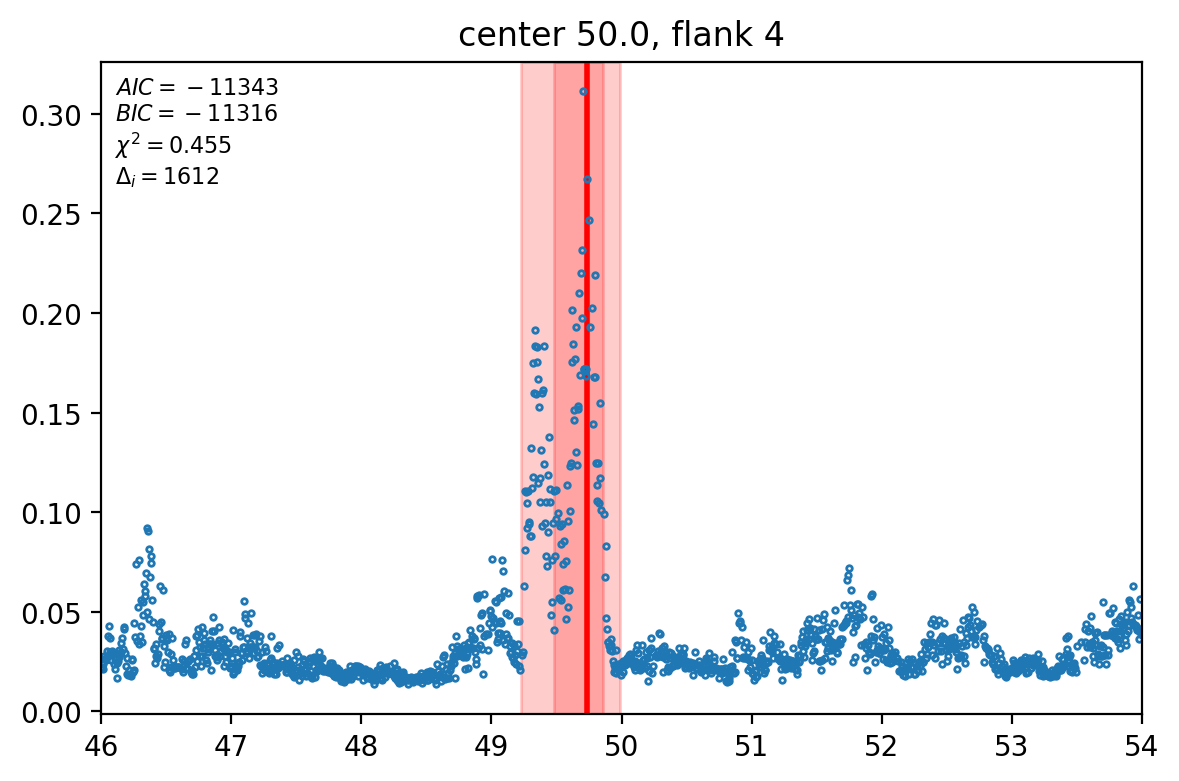

[[Model]]
    Model(skewed_exponential_peak)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 107
    # data points      = 1412
    # variables        = 5
    chi-square         = 0.45508500
    reduced chi-square = 3.2344e-04
    Akaike info crit   = -11342.5273
    Bayesian info crit = -11316.2635
    R-squared          = 0.68248400
[[Variables]]
    center:     49.7305527 +/- 0.00497038 (0.01%) (init = 50)
    amplitude:  0.18530169 +/- 0.00470882 (2.54%) (init = 0.5)
    decay:      0.17927142 +/- 0.00705801 (3.94%) (init = 0.5)
    skew:       0.50000000 +/- 0.02544788 (5.09%) (init = 0)
    baseline:   0.02838980 +/- 5.3229e-04 (1.87%) (init = 0.0202)
    ceiling:    1 (fixed)
    floor:      0 (fixed)
[[Correlations]] (unreported correlations are < 0.100)
    C(center, skew)      = 0.730
    C(amplitude, decay)  = -0.670
    C(decay, skew)       = -0.419
    C(center, decay)     = -0.363
    C(decay, baseline)   = -0.303
    C(center, amplitude) = 0.2

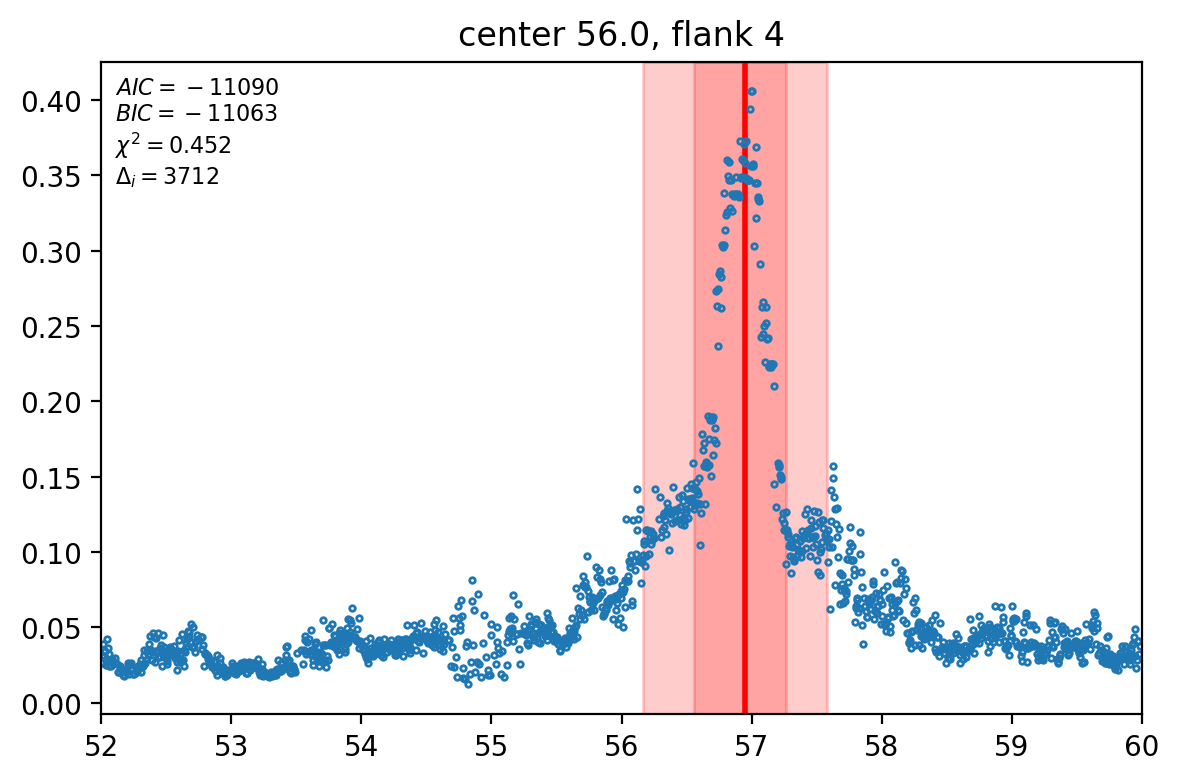

[[Model]]
    Model(skewed_exponential_peak)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 86
    # data points      = 1383
    # variables        = 5
    chi-square         = 0.45217097
    reduced chi-square = 3.2814e-04
    Akaike info crit   = -11089.5504
    Bayesian info crit = -11063.3903
    R-squared          = 0.93212035
[[Variables]]
    center:     56.9455212 +/- 0.00325705 (0.01%) (init = 56)
    amplitude:  0.34806346 +/- 0.00322707 (0.93%) (init = 0.5)
    decay:      0.35179975 +/- 0.00524637 (1.49%) (init = 0.5)
    skew:       0.15573968 +/- 0.01904643 (12.23%) (init = 0)
    baseline:   0.03792705 +/- 6.0753e-04 (1.60%) (init = 0.0202)
    ceiling:    1 (fixed)
    floor:      0 (fixed)
[[Correlations]] (unreported correlations are < 0.100)
    C(center, skew)     = 0.702
    C(amplitude, decay) = -0.617
    C(decay, baseline)  = -0.465
center 56.0 flank size 8


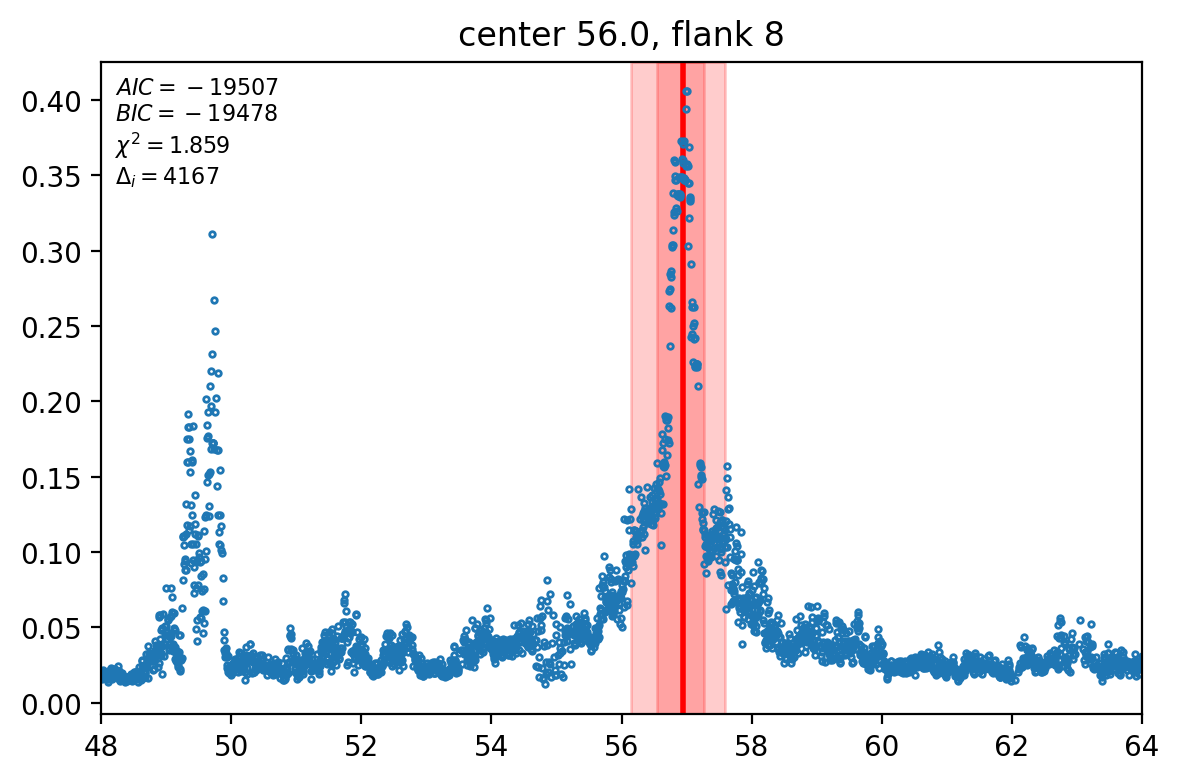

[[Model]]
    Model(skewed_exponential_peak)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 93
    # data points      = 2683
    # variables        = 5
    chi-square         = 1.85948769
    reduced chi-square = 6.9436e-04
    Akaike info crit   = -19507.1879
    Bayesian info crit = -19477.7145
    R-squared          = 0.78900473
[[Variables]]
    center:     56.9452868 +/- 0.00479150 (0.01%) (init = 56)
    amplitude:  0.34750322 +/- 0.00465259 (1.34%) (init = 0.5)
    decay:      0.35825857 +/- 0.00720974 (2.01%) (init = 0.5)
    skew:       0.15368454 +/- 0.02749870 (17.89%) (init = 0)
    baseline:   0.03664677 +/- 5.6438e-04 (1.54%) (init = 0.0202)
    ceiling:    1 (fixed)
    floor:      0 (fixed)
[[Correlations]] (unreported correlations are < 0.100)
    C(center, skew)     = 0.703
    C(amplitude, decay) = -0.662
    C(decay, baseline)  = -0.321
center 57.0 flank size 4


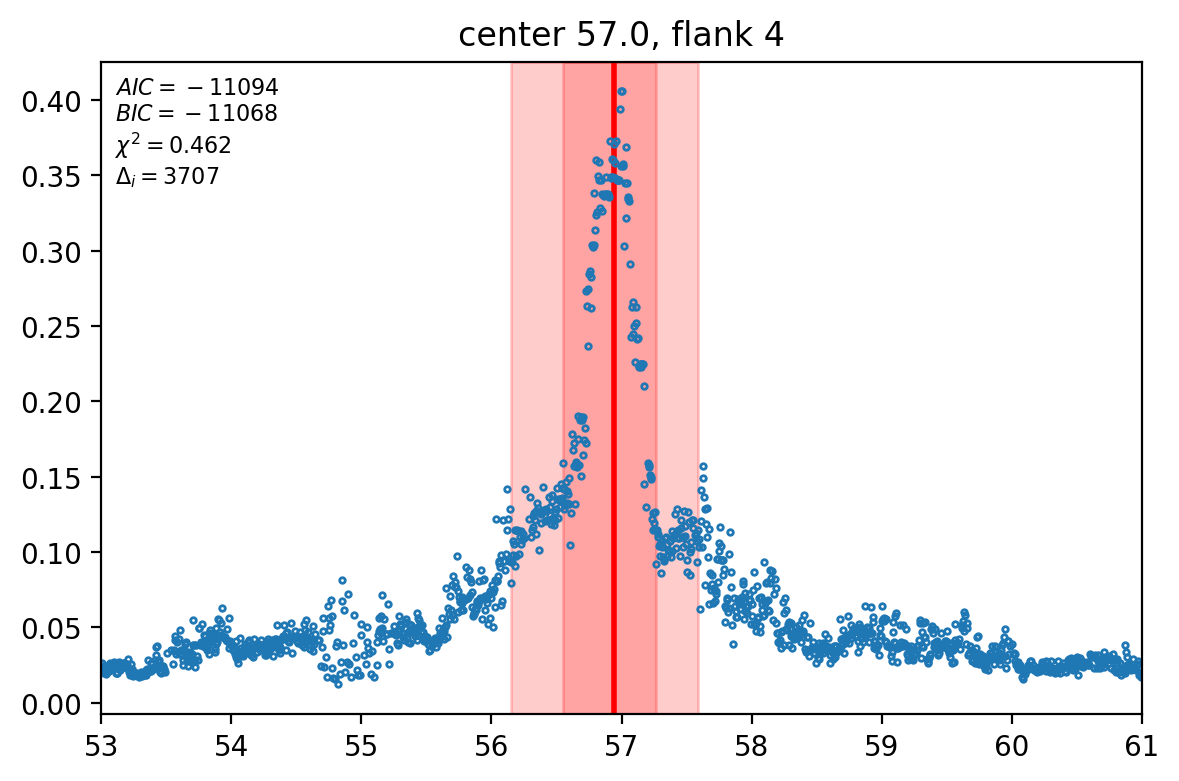

[[Model]]
    Model(skewed_exponential_peak)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 55
    # data points      = 1387
    # variables        = 5
    chi-square         = 0.46245649
    reduced chi-square = 3.3463e-04
    Akaike info crit   = -11094.4624
    Bayesian info crit = -11068.2879
    R-squared          = 0.93131450
[[Variables]]
    center:     56.9453290 +/- 0.00332119 (0.01%) (init = 57)
    amplitude:  0.34757605 +/- 0.00323384 (0.93%) (init = 0.5)
    decay:      0.35736123 +/- 0.00535843 (1.50%) (init = 0.5)
    skew:       0.15404876 +/- 0.01910984 (12.41%) (init = 0)
    baseline:   0.03682500 +/- 6.1476e-04 (1.67%) (init = 0.0202)
    ceiling:    1 (fixed)
    floor:      0 (fixed)
[[Correlations]] (unreported correlations are < 0.100)
    C(center, skew)     = 0.703
    C(amplitude, decay) = -0.616
    C(decay, baseline)  = -0.469
center 57.0 flank size 8


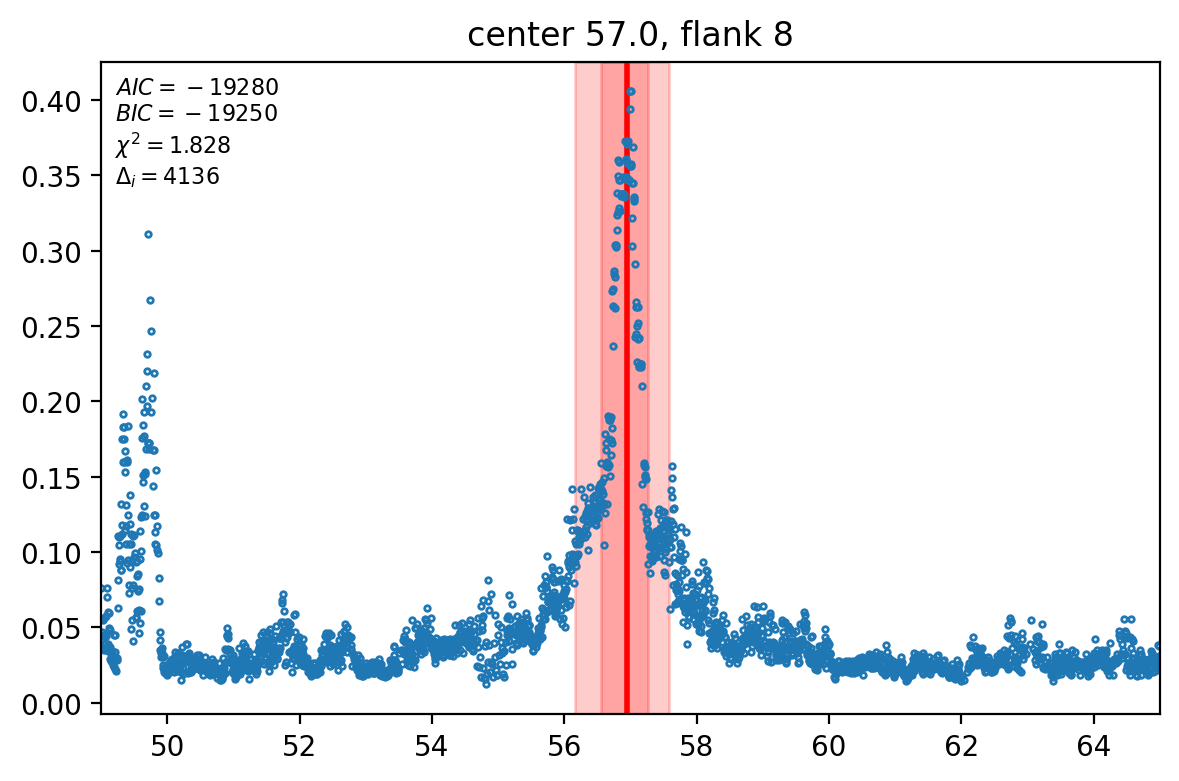

[[Model]]
    Model(skewed_exponential_peak)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 55
    # data points      = 2650
    # variables        = 5
    chi-square         = 1.82790811
    reduced chi-square = 6.9108e-04
    Akaike info crit   = -19279.7282
    Bayesian info crit = -19250.3166
    R-squared          = 0.79066627
[[Variables]]
    center:     56.9454049 +/- 0.00475523 (0.01%) (init = 57)
    amplitude:  0.34777265 +/- 0.00466075 (1.34%) (init = 0.5)
    decay:      0.35526194 +/- 0.00715900 (2.02%) (init = 0.5)
    skew:       0.15470958 +/- 0.02752804 (17.79%) (init = 0)
    baseline:   0.03723158 +/- 5.6682e-04 (1.52%) (init = 0.0202)
    ceiling:    1 (fixed)
    floor:      0 (fixed)
[[Correlations]] (unreported correlations are < 0.100)
    C(center, skew)     = 0.703
    C(amplitude, decay) = -0.662
    C(decay, baseline)  = -0.322
center 58.0 flank size 4
center 58.0 flank size 8
center 59.0 flank size 4
center 59.0 flank size 8
c

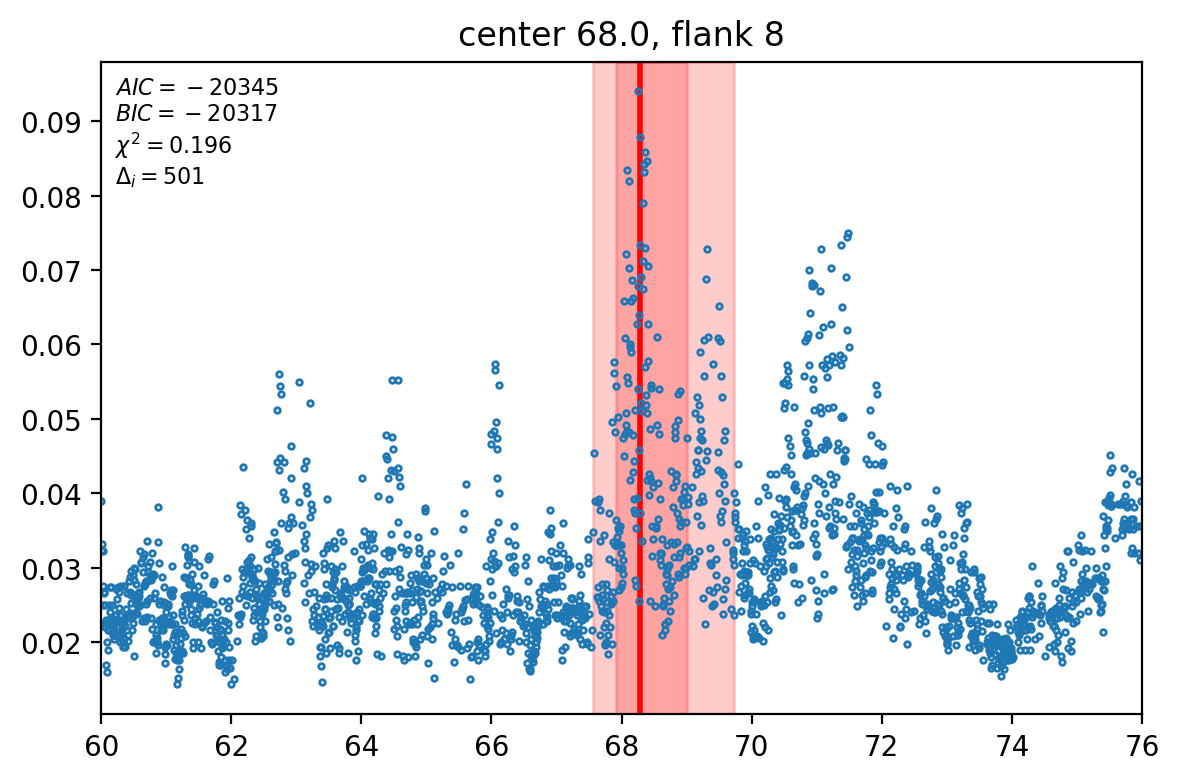

[[Model]]
    Model(skewed_exponential_peak)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 184
    # data points      = 2184
    # variables        = 5
    chi-square         = 0.19566464
    reduced chi-square = 8.9796e-05
    Akaike info crit   = -20345.4619
    Bayesian info crit = -20317.0173
    R-squared          = 0.20801139
[[Variables]]
    center:     68.2791220 +/- 0.02493564 (0.04%) (init = 68)
    amplitude:  0.03000009 +/- 0.00146514 (4.88%) (init = 0.5)
    decay:      0.51081007 +/- 0.04235549 (8.29%) (init = 0.5)
    skew:      -0.49999901 +/- 0.11059094 (22.12%) (init = 0)
    baseline:   0.02797992 +/- 2.3853e-04 (0.85%) (init = 0.0202)
    ceiling:    1 (fixed)
    floor:      0 (fixed)
[[Correlations]] (unreported correlations are < 0.100)
    C(center, skew)     = 0.707
    C(amplitude, decay) = -0.611
    C(decay, baseline)  = -0.381
    C(decay, skew)      = 0.288
    C(center, decay)    = 0.223
center 69.0 flank size 4
center 69.0

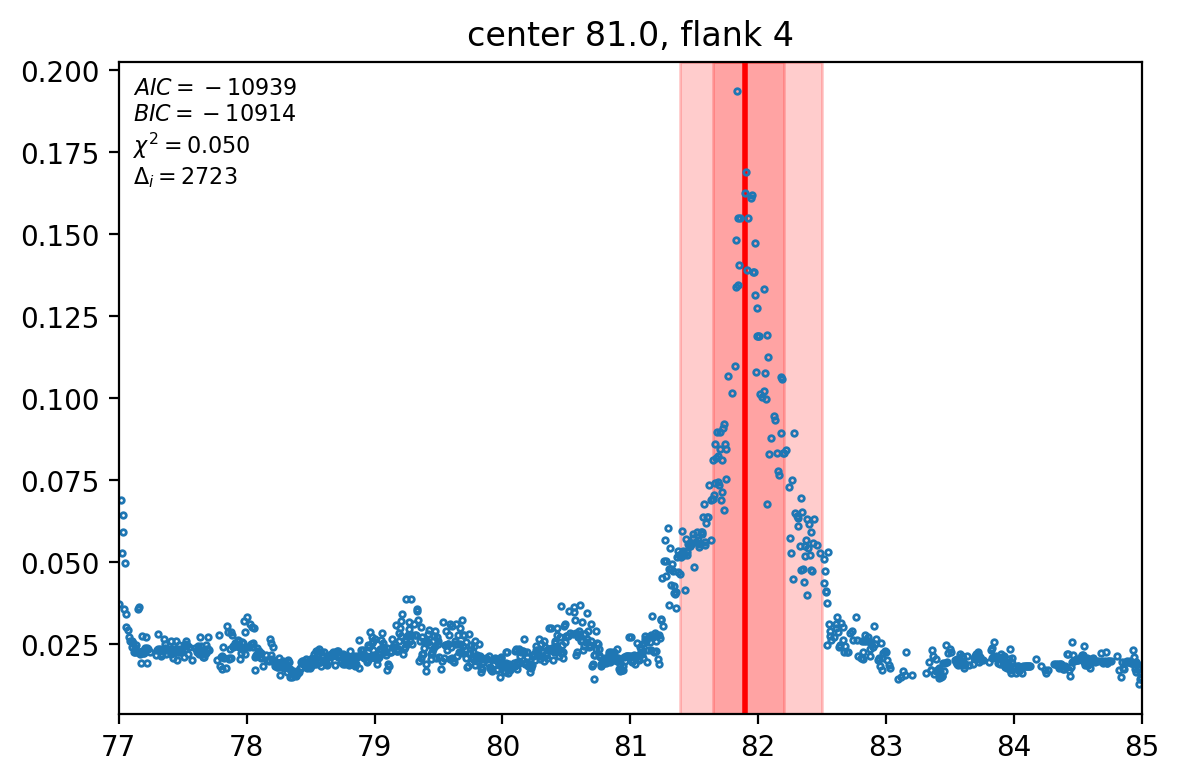

[[Model]]
    Model(skewed_exponential_peak)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 88
    # data points      = 1095
    # variables        = 5
    chi-square         = 0.04974557
    reduced chi-square = 4.5638e-05
    Akaike info crit   = -10939.2810
    Bayesian info crit = -10914.2885
    R-squared          = 0.91739169
[[Variables]]
    center:     81.8994170 +/- 0.00354195 (0.00%) (init = 81)
    amplitude:  0.14357573 +/- 0.00181416 (1.26%) (init = 0.5)
    decay:      0.27768482 +/- 0.00495171 (1.78%) (init = 0.5)
    skew:      -0.11402637 +/- 0.02375026 (20.83%) (init = 0)
    baseline:   0.02180194 +/- 2.3771e-04 (1.09%) (init = 0.0202)
    ceiling:    1 (fixed)
    floor:      0 (fixed)
[[Correlations]] (unreported correlations are < 0.100)
    C(center, skew)      = 0.740
    C(amplitude, decay)  = -0.693
    C(decay, baseline)   = -0.386
    C(center, amplitude) = -0.114
    C(center, decay)     = 0.105
center 81.0 flank size 8


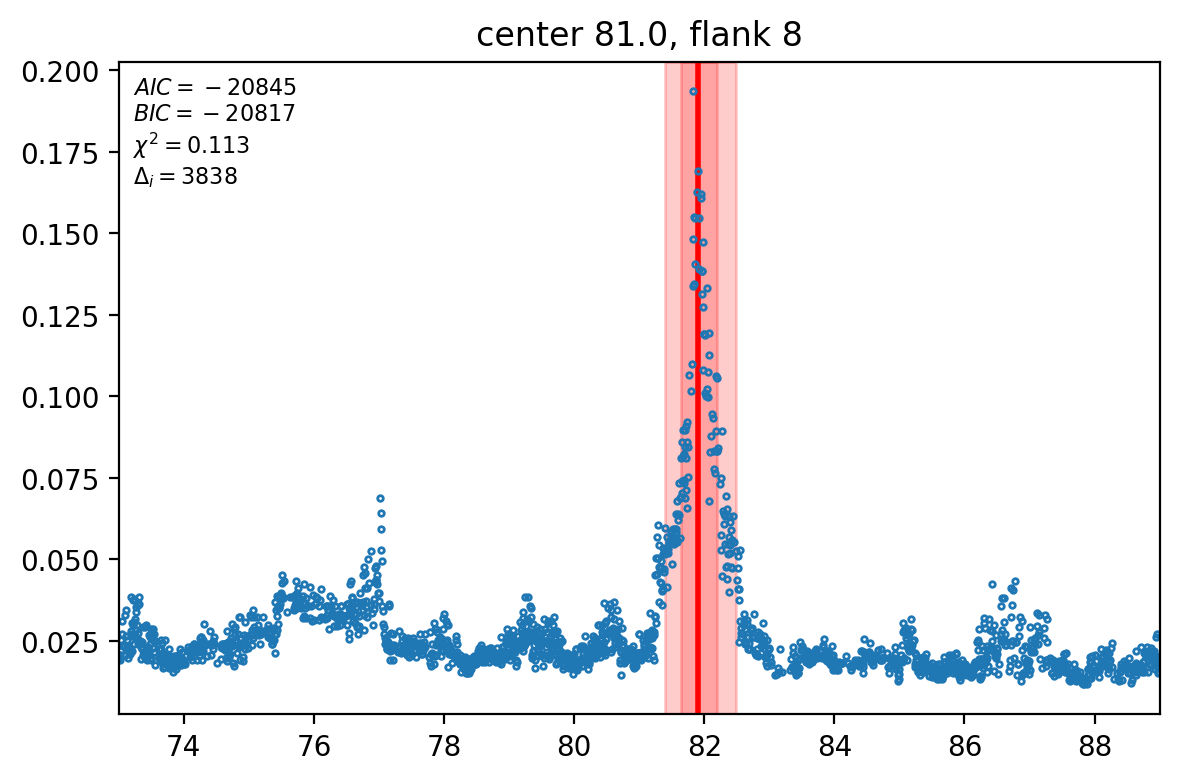

[[Model]]
    Model(skewed_exponential_peak)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 88
    # data points      = 2119
    # variables        = 5
    chi-square         = 0.11266802
    reduced chi-square = 5.3296e-05
    Akaike info crit   = -20845.2176
    Bayesian info crit = -20816.9241
    R-squared          = 0.83717808
[[Variables]]
    center:     81.8986332 +/- 0.00378193 (0.00%) (init = 81)
    amplitude:  0.14370961 +/- 0.00198570 (1.38%) (init = 0.5)
    decay:      0.27129804 +/- 0.00505704 (1.86%) (init = 0.5)
    skew:      -0.11988692 +/- 0.02594045 (21.64%) (init = 0)
    baseline:   0.02262491 +/- 1.7027e-04 (0.75%) (init = 0.0202)
    ceiling:    1 (fixed)
    floor:      0 (fixed)
[[Correlations]] (unreported correlations are < 0.100)
    C(center, skew)      = 0.740
    C(amplitude, decay)  = -0.719
    C(decay, baseline)   = -0.265
    C(center, amplitude) = -0.106
center 82.0 flank size 4


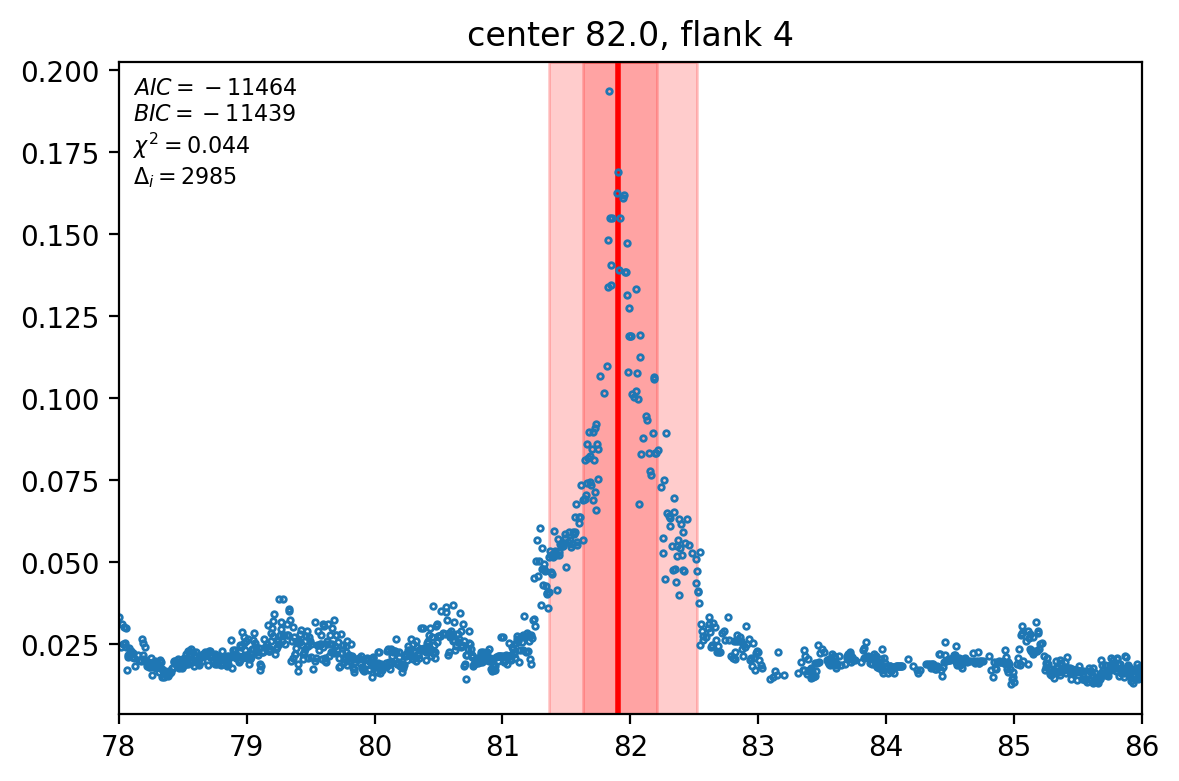

[[Model]]
    Model(skewed_exponential_peak)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 49
    # data points      = 1129
    # variables        = 5
    chi-square         = 0.04354748
    reduced chi-square = 3.8743e-05
    Akaike info crit   = -11464.0169
    Bayesian info crit = -11438.8715
    R-squared          = 0.92944484
[[Variables]]
    center:     81.9008220 +/- 0.00332628 (0.00%) (init = 82)
    amplitude:  0.14328071 +/- 0.00163698 (1.14%) (init = 0.5)
    decay:      0.28835353 +/- 0.00465890 (1.62%) (init = 0.5)
    skew:      -0.10394950 +/- 0.02150531 (20.69%) (init = 0)
    baseline:   0.02050343 +/- 2.1603e-04 (1.05%) (init = 0.0202)
    ceiling:    1 (fixed)
    floor:      0 (fixed)
[[Correlations]] (unreported correlations are < 0.100)
    C(center, skew)      = 0.740
    C(amplitude, decay)  = -0.693
    C(decay, baseline)   = -0.387
    C(center, amplitude) = -0.127
    C(center, decay)     = 0.111
center 82.0 flank size 8


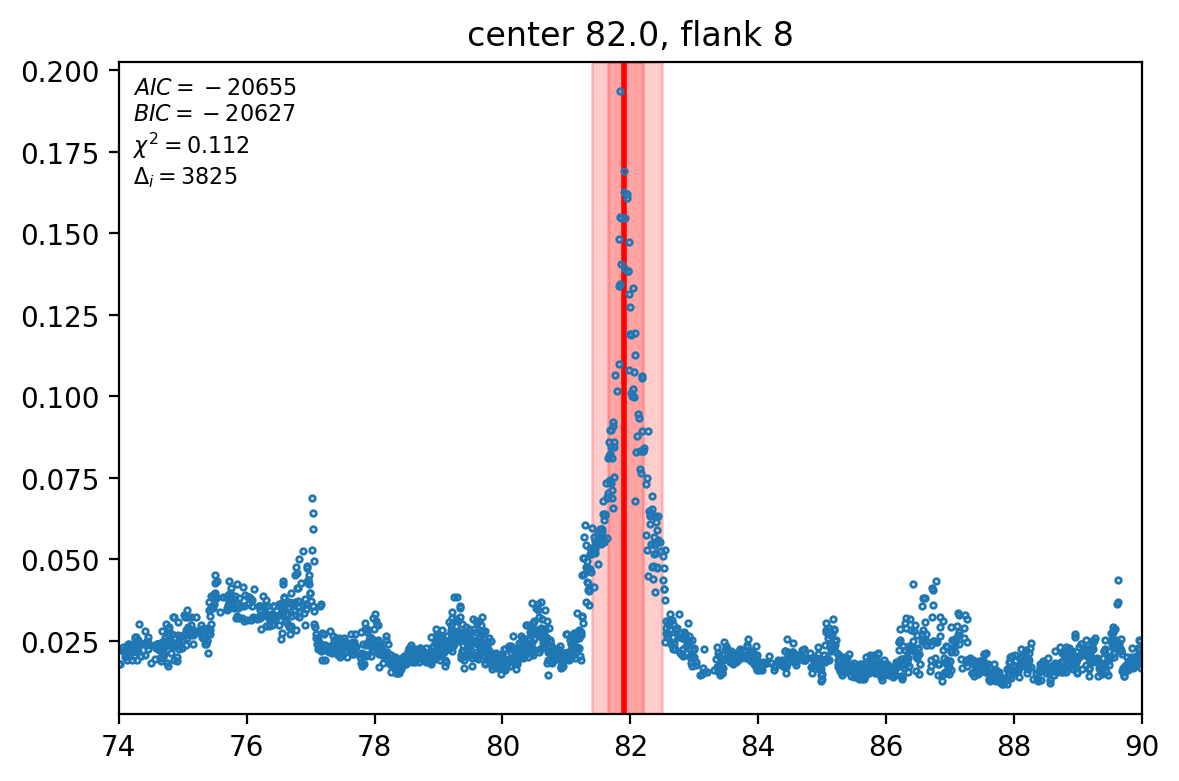

[[Model]]
    Model(skewed_exponential_peak)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 43
    # data points      = 2100
    # variables        = 5
    chi-square         = 0.11180274
    reduced chi-square = 5.3366e-05
    Akaike info crit   = -20655.4948
    Bayesian info crit = -20627.2463
    R-squared          = 0.83878645
[[Variables]]
    center:     81.8987919 +/- 0.00379359 (0.00%) (init = 82)
    amplitude:  0.14368620 +/- 0.00198165 (1.38%) (init = 0.5)
    decay:      0.27259720 +/- 0.00507581 (1.86%) (init = 0.5)
    skew:      -0.11867754 +/- 0.02589969 (21.82%) (init = 0)
    baseline:   0.02245408 +/- 1.7134e-04 (0.76%) (init = 0.0202)
    ceiling:    1 (fixed)
    floor:      0 (fixed)
[[Correlations]] (unreported correlations are < 0.100)
    C(center, skew)      = 0.740
    C(amplitude, decay)  = -0.719
    C(decay, baseline)   = -0.266
    C(center, amplitude) = -0.107
center 83.0 flank size 4
center 83.0 flank size 8
center 84.0 fl

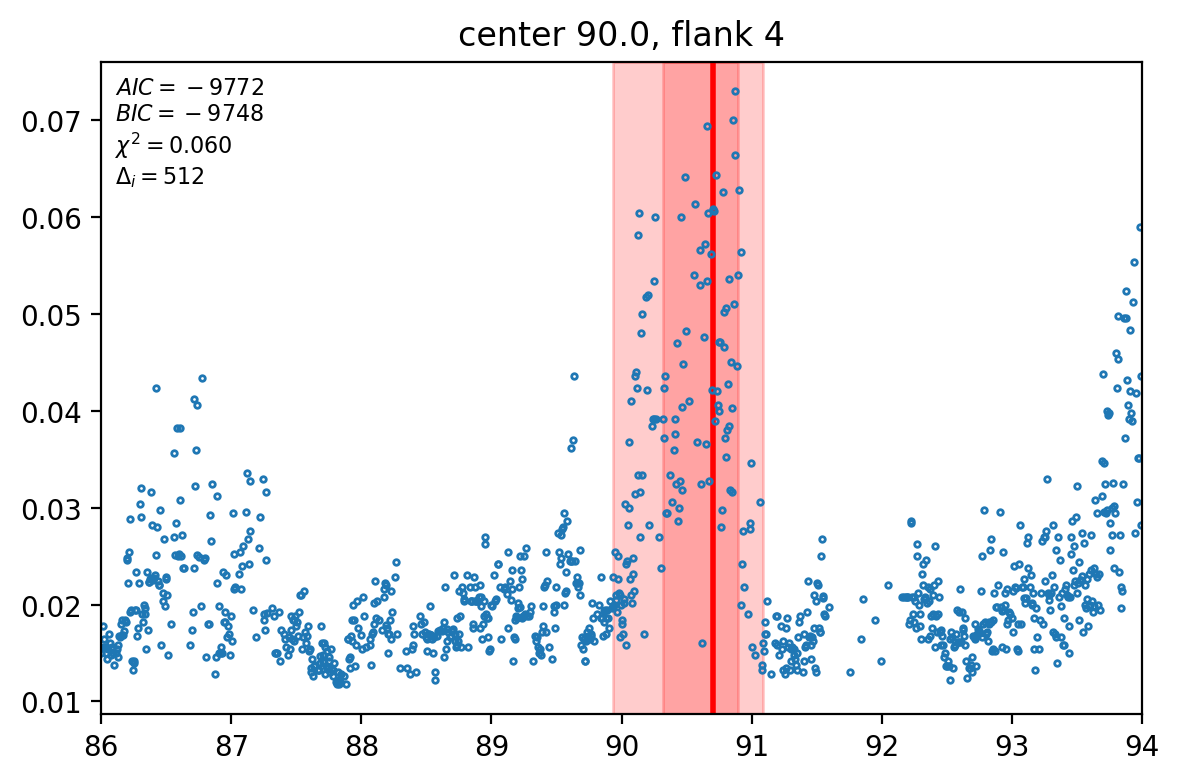

[[Model]]
    Model(skewed_exponential_peak)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 127
    # data points      = 1006
    # variables        = 5
    chi-square         = 0.06020353
    reduced chi-square = 6.0143e-05
    Akaike info crit   = -9772.10415
    Bayesian info crit = -9747.53546
    R-squared          = 0.40348914
[[Variables]]
    center:     90.7041132 +/- 0.01335874 (0.01%) (init = 90)
    amplitude:  0.03710170 +/- 0.00185844 (5.01%) (init = 0.5)
    decay:      0.27292909 +/- 0.02266016 (8.30%) (init = 0.5)
    skew:       0.49999999 +/- 0.11108048 (22.22%) (init = 0)
    baseline:   0.02027391 +/- 2.8968e-04 (1.43%) (init = 0.0202)
    ceiling:    1 (fixed)
    floor:      0 (fixed)
[[Correlations]] (unreported correlations are < 0.100)
    C(center, skew)     = 0.713
    C(amplitude, decay) = -0.594
    C(decay, skew)      = -0.406
    C(decay, baseline)  = -0.374
    C(center, decay)    = -0.258
center 90.0 flank size 8
center 91

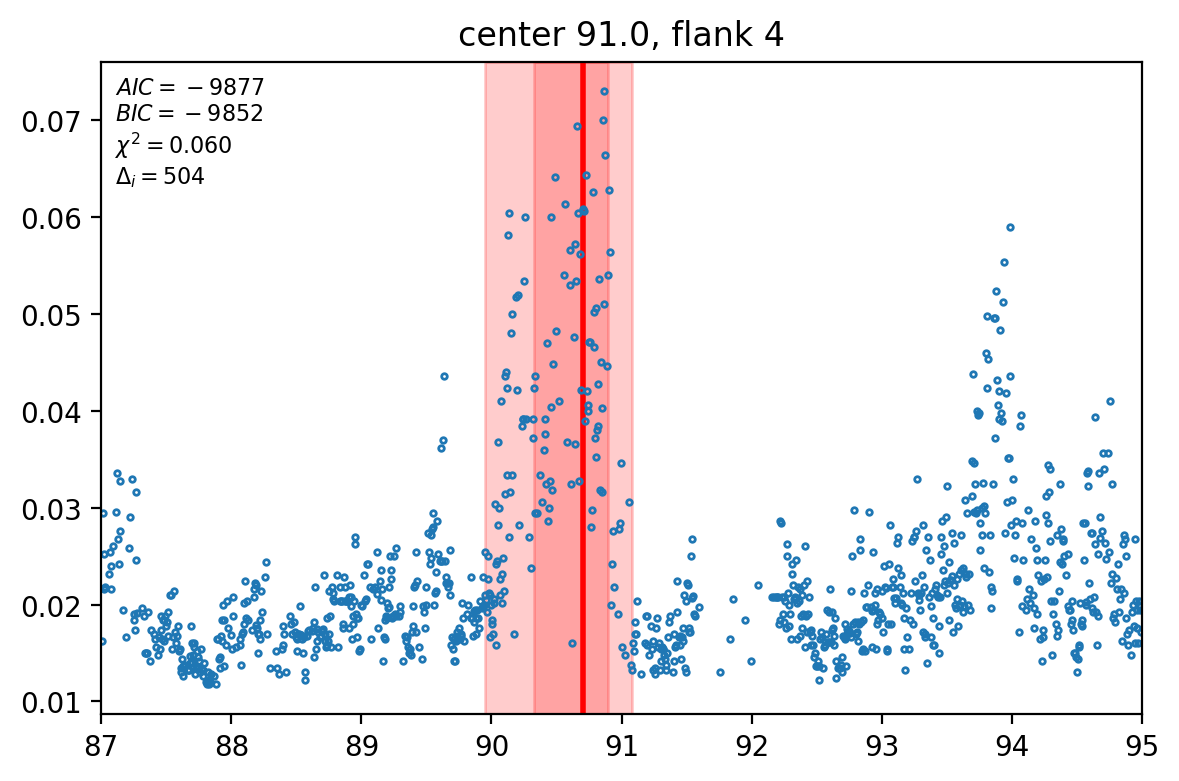

[[Model]]
    Model(skewed_exponential_peak)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 96
    # data points      = 1016
    # variables        = 5
    chi-square         = 0.06036721
    reduced chi-square = 5.9710e-05
    Akaike info crit   = -9876.63278
    Bayesian info crit = -9852.01464
    R-squared          = 0.39596068
[[Variables]]
    center:     90.7043893 +/- 0.01324225 (0.01%) (init = 91)
    amplitude:  0.03686589 +/- 0.00187086 (5.07%) (init = 0.5)
    decay:      0.26712250 +/- 0.02240746 (8.39%) (init = 0.5)
    skew:       0.49999999 +/- 0.11254021 (22.51%) (init = 0)
    baseline:   0.02058368 +/- 2.8548e-04 (1.39%) (init = 0.0202)
    ceiling:    1 (fixed)
    floor:      0 (fixed)
[[Correlations]] (unreported correlations are < 0.100)
    C(center, skew)     = 0.713
    C(amplitude, decay) = -0.596
    C(decay, skew)      = -0.405
    C(decay, baseline)  = -0.368
    C(center, decay)    = -0.259
center 91.0 flank size 8
center 92.

,cohort_id,contig,gcenter,pcenter,delta_i,stat_max,gpos_max,ppos_max,focus_gstart,focus_gstop,...,amplitude,decay,skew,decay_left,decay_right,baseline,aic,bic,rss,constant_aic
0,BF-09_Houet_colu_2012_Q3,2R,40.419524,20209762,837,0.1064,40.480698,20240349,40.249642,40.507607,...,0.037534,0.489307,0.473796,0.679529,0.352334,0.018956,-12801.976297,-12775.896422,0.111061,-11964.962518
1,BF-09_Houet_colu_2012_Q3,2R,40.419523,20209762,949,0.1064,40.480698,20240349,40.261485,40.502490,...,0.037492,0.458030,0.464823,0.632150,0.331870,0.019597,-25584.816598,-25555.212550,0.253377,-24634.928495
2,BF-09_Houet_colu_2012_Q3,2R,40.480698,20240349,765,0.1064,40.480698,20240349,40.336366,40.552865,...,0.037216,0.408237,0.499986,0.577329,0.288670,0.020841,-12818.276500,-12792.207659,0.107241,-12052.443697
3,BF-09_Houet_colu_2012_Q3,2R,40.480698,20240349,857,0.1064,40.480698,20240349,40.333887,40.554108,...,0.037530,0.415258,0.499950,0.587243,0.293642,0.020512,-25526.565135,-25496.955643,0.261702,-24669.031125
4,BF-09_Houet_colu_2012_Q3,2R,49.401772,24700887,1011,0.3112,49.703554,24851777,49.350658,49.504000,...,0.125049,0.289145,-0.500000,0.204456,0.408913,0.026507,-10786.376885,-10760.088347,0.704172,-9774.438614
5,BF-09_Houet_colu_2012_Q3,2R,49.730553,24865277,1611,0.3112,49.703554,24851777,49.667171,49.762244,...,0.185302,0.179271,0.500000,0.253528,0.126764,0.028390,-11342.527288,-11316.263476,0.455085,-9730.642685
6,BF-09_Houet_colu_2012_Q3,2R,56.945521,28472761,3712,0.4058,56.992114,28496057,56.847546,57.024471,...,0.348063,0.351800,0.155740,0.391902,0.315801,0.037927,-11089.550361,-11063.390309,0.452171,-7377.254037
7,BF-09_Houet_colu_2012_Q3,2R,56.945287,28472644,4166,0.4058,56.992114,28496057,56.845654,57.025801,...,0.347503,0.358259,0.153685,0.398529,0.322057,0.036647,-19507.187930,-19477.714476,1.859488,-15340.655759
8,BF-09_Houet_colu_2012_Q3,2R,56.945329,28472665,3706,0.4058,56.992114,28496057,56.845921,57.025621,...,0.347576,0.357361,0.154049,0.397631,0.321169,0.036825,-11094.462397,-11068.287905,0.462456,-7387.775160
9,BF-09_Houet_colu_2012_Q3,2R,56.945405,28472703,4136,0.4058,56.992114,28496057,56.846536,57.025189,...,0.347773,0.355262,0.154710,0.395477,0.319136,0.037232,-19279.728190,-19250.316615,1.827908,-15143.590625


In [20]:
# set up results
results = []

# main loop, iterate along the genome
for gcenter in np.arange(scan_start, scan_stop, scan_interval):

    for gflank in gflanks:

        print('center', gcenter, 'flank size', gflank)

        result = fit_exponential_peak(
            ppos=ppos, 
            gpos=gpos, 
            stat_filtered=h12_filtered, 
            gcenter=gcenter, 
            gflank=gflank, 
            scan_interval=scan_interval,
            init_amplitude=init_amplitude,
            min_amplitude=min_amplitude,
            max_amplitude=max_amplitude,
            init_decay=init_decay,
            min_decay=min_decay,
            init_skew=init_skew,
            min_skew=min_skew,
            max_skew=max_skew,
            init_baseline=init_baseline,
            min_baseline=min_baseline,
            max_baseline=max_baseline,
            min_delta_aic=min_delta_aic,
            debug=debug,
        )

        if result is not None:
            results.append(result)

df_signals = pd.DataFrame.from_records(results)
df_signals

In [21]:
def dedup_signals(df_signals):
    
    keep = list(range(len(df_signals)))
    for i, this in df_signals.iterrows():
        for j, that in df_signals.iterrows():
            if i != j:
                # thank you Ned Batchelder
                # https://nedbatchelder.com/blog/201310/range_overlap_in_two_compares.html
                disjoint = that.span1_gstart > this.span1_gstop or that.span1_gstop < this.span1_gstart
                if not disjoint and that.delta_i > this.delta_i:
                    keep.remove(i)
                    break
    return df_signals.iloc[keep].copy()


In [22]:
df_signals_dedup = dedup_signals(df_signals)
df_signals_dedup

,cohort_id,contig,gcenter,pcenter,delta_i,stat_max,gpos_max,ppos_max,focus_gstart,focus_gstop,...,amplitude,decay,skew,decay_left,decay_right,baseline,aic,bic,rss,constant_aic
1,BF-09_Houet_colu_2012_Q3,2R,40.419523,20209762,949,0.1064,40.480698,20240349,40.261485,40.502490,...,0.037492,0.458030,0.464823,0.632150,0.331870,0.019597,-25584.816598,-25555.212550,0.253377,-24634.928495
5,BF-09_Houet_colu_2012_Q3,2R,49.730553,24865277,1611,0.3112,49.703554,24851777,49.667171,49.762244,...,0.185302,0.179271,0.500000,0.253528,0.126764,0.028390,-11342.527288,-11316.263476,0.455085,-9730.642685
7,BF-09_Houet_colu_2012_Q3,2R,56.945287,28472644,4166,0.4058,56.992114,28496057,56.845654,57.025801,...,0.347503,0.358259,0.153685,0.398529,0.322057,0.036647,-19507.187930,-19477.714476,1.859488,-15340.655759
10,BF-09_Houet_colu_2012_Q3,2R,68.279122,34139562,501,0.0940,68.244706,34122353,68.188823,68.459721,...,0.030000,0.510810,-0.499999,0.361198,0.722394,0.027980,-20345.461893,-20317.017326,0.195665,-19844.135026
12,BF-09_Houet_colu_2012_Q3,2R,81.898633,40949317,3838,0.1936,81.833786,40916893,81.836217,81.972335,...,0.143710,0.271298,-0.119887,0.249665,0.294806,0.022625,-20845.217590,-20816.924092,0.112668,-17007.024578
15,BF-09_Houet_colu_2012_Q3,2R,90.704113,45352057,511,0.0730,90.868374,45434187,90.607618,90.752361,...,0.037102,0.272929,0.500000,0.385980,0.192990,0.020274,-9772.104151,-9747.535465,0.060204,-9260.346368


## Write outputs

In [24]:
outdir = "build/h12-signal-detection"

with open(here() / outdir / f"{cohort_id}_{contig}.csv", mode="w") as output_file:
    df_signals_dedup.to_csv(output_file, index=False)